![title](./images/logo_nao_digital.png)

# 4 Conocimientos sobre librerías de visualización estática

## 1. Objetivo

Para enriquecer el análisis de Oilst y hacerlo más accesible al público no especializado, el equipo de `Brasil BI Consulting` decidió crear visualizaciones estáticas, es decir sin animaciones o filtros interactivos, a partir de los datos de las órdenes de los clientes.

Con ello en mente, el objetivo de la presente sección será trabajar con la librería `Seaborn` de Python (https://seaborn.pydata.org) para abundar en el análisis correspondiente. Seaborn es una librería para implementar gráficos estadísticos en Python, que se basa en `matplotlib` y se integra estrechamente con las estructuras de datos de `pandas`.

## 2. Librerias de trabajo

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Libreria de visualización
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

## 3. Lectura de datos

Leeremos primeros los datos del e-commerce que procesamos previamente en Pandas.

In [3]:
# Primero indicamos la ruta a la carpeta de de tu computadora 
# donde se ubican los datos procesados del E-commerce
# Ejemplo: "C:\Usuarios\[tu nombre]\Descargas"

DATA_PATH="/Users/Usuario/Desktop/ANÁLISIS DE DATOS/Recursos DN_COM_58 (copia)/"

In [4]:
FILE_CONSOLIDATED_DATA = 'results.csv'

Recordemos que algunas de las columnas que contienen fechas deben ser convertidas al formato correspondiente, lo cual se puede llevar a cabo de forma automática usando el parámetro de `parse_dates`:

In [5]:
columns_dates=[
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
    ]

oilst = pd.read_csv(
    os.path.join(DATA_PATH, FILE_CONSOLIDATED_DATA),
    parse_dates=columns_dates
    )

La información general de esta tabla la podemos obtener, como ya sabemos, a través del comando `.info`

In [6]:
oilst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   distance_distribution_center   96470 non-null  float64       
 9   year                           99441 non-null  int64         
 10  month                          99441 non-null  int64         
 11  quarter        

También definiremos un dataframe que contiene únicamente a las órdenes que tienen estatus de entrega completada, es decir, que satisfacen con la condición de que la columna `order_status` es igual al valor `delivered`.

In [7]:
delivered = oilst.query("order_status == 'delivered'")

## 2. Análisis univariado

Seaborn es una librería de visualización de datos de Python basada en matplotlib, contando entre sus ventajas 
la facilidad de uso y personalización, una cantidad considerable de visualizaciones disponibles y la posibildad de tomar como datos de entradas a dataframes de Pandas.


### 2.1 Análisis de diferencia entre tiempo de entrega real y estimado

Para comenzar, podemos explorar nuevamente la variable **delta_days**, que como sabemos es la diferencia entre el tiempo estimado de la entrega y cuando se llevó a cabo la entrega realmente , reportándose en días. Es importante recalcar que:

* Si `delta_days <= 0`, significa que el pedido llegó que no hubo atraso en la entrega,
* Si `0 < delta_days < 3`, ello refiere que el pedido se entregó en un intervalo de tiempo moderado, que es aceptable de acuerdo a las políticas de negocio de `Oilst`,
* Mientras que si  `delta_days > 3`, ello denota que 

#### 2.2.1 Histogramas de frequencias y función de distribución acumulativa empírica

Como se ha calculo previamente, la diferencia entre tiempo de entrega real y estimado es en promedio de `-11 días`, es decir, en general los envíos suelen llegar antes de lo esperado.

In [8]:
print("Promedio de la diferencia de tiempo de estimado entrega y real: ", round(delivered["delta_days"].mean(),2), ' días')

Promedio de la diferencia de tiempo de estimado entrega y real:  -11.18  días


Ello se puede constatar empleando el concepto estadístico de **percentiles**, el cual se refiere es una forma de medir la posición de un valor en un conjunto de datos. Imagina que tienes un conjunto de datos, por ejemplo, las alturas de un grupo de personas. Si ordenas estas alturas de menor a mayor, el percentil te dirá en qué posición se encuentra una altura en particular de una persona con las alturas del resto de las demás.

Por ejemplo, si la altura de una persona se encuentra en el percentil 75, significa que su altura es mayor que el 75% de las alturas en el conjunto de datos. De manera similar, si la altura de una persona se encuentra en el percentil 25, significa que su altura es mayor que el 25% de las alturas en el conjunto de datos.

En Pandas, estos se pueden calcular con usando la utilidad `.describe` y una lista que indica las posiciones en su variables `percentiles`.

Con ello en mente, podemos notar que la mayorñia de los datos, hasta el percentil que corresponde al 90%, tiene un valor `delta_days` en un tiempo es un valor negativo (`-1.14 días`). Es decir, se entregan en su mayoría antes del tiempo que se les comunica a los clientes:

In [9]:
# Lista de percentiles a calculas (desde el 10%, 20%, ..., 90% y 100% )
percentiles = [0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9,1]

# Calculo de percentoles
delivered[["delta_days"]].describe(
    percentiles=percentiles
    ).round(2)

,delta_days
count,96470.00
mean,-11.18
std,10.18
min,-146.02
10%,-21.29
20%,-17.77
30%,-15.12
40%,-13.24
50%,-11.95
60%,-9.48


Para apreciar de mejor forma esta distribución, podemos acudir al concepto de **histograma de frecuencias**, el cual es una herramienta gráfica que muestra cuantas veces ocurren las diferentes valores en un conjunto de datos. En otras palabras, representa cuántas veces aparece cada valor en el conjunto de datos. Éste se puede representar de manera gráfica con barras que muestran la frecuencia con la que aparece cada uno de los valores que típicamente se agrupan en intervalos para facilitar el conteo (`bins`, en inglés).

 Un histograma puede ayudarnos a identificar patrones en la distribución de los datos, como si las notas están concentradas en un rango estrecho o si están más dispersas.

En seaborn, se puede obtener usando la función `histplot`, especificando la cantidad de particiones en lo que se agruparán los datos para su contabilización (`bins`).

[Text(0.5, 1.0, 'Fig. 1 Histograma de frecuencias de `delta_days`')]

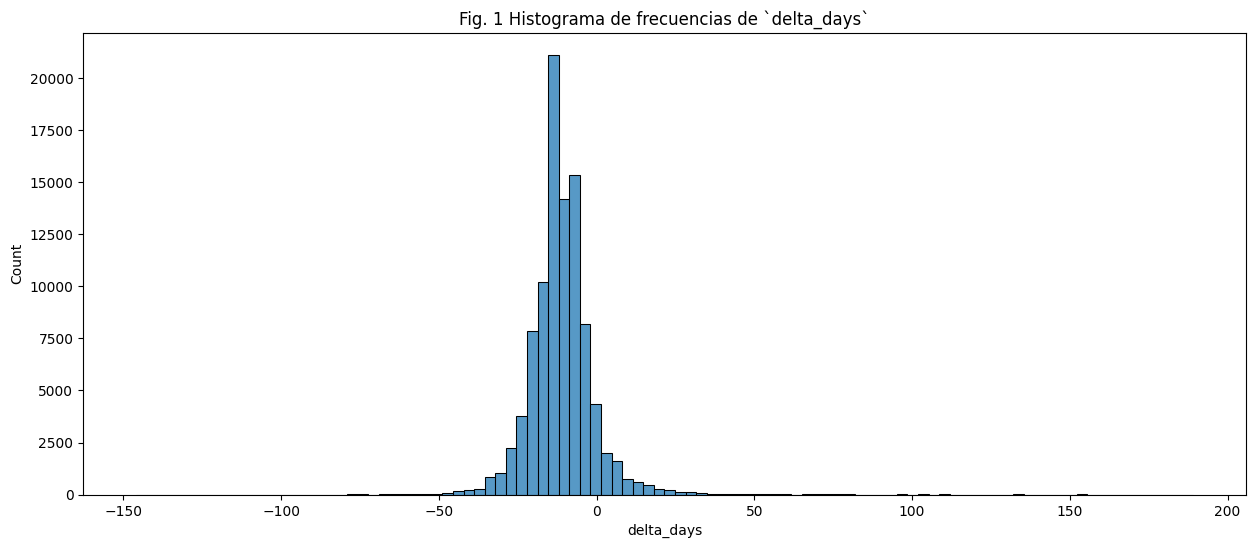

In [10]:
# Especifica el tamaño de la figura
plt.figure(figsize = (15,6))

sns.histplot(
    data=delivered["delta_days"],
    bins=100
    ).set(
        title='Fig. 1 Histograma de frecuencias de `delta_days`'
        )

**Nota:** En este caso, la función `histplot` se ha alimentado directamente de la columna `delivered["delta_days"]` del dataframe de Pandas en donde leímos los datos.

Como se aprecia, la diferencia de tiempo de estimado entrega y real tienen un distribución sesgada a la izquierda, hacia valores negativos, lo que concuerda con la idea de que casi todos los pedidos llegan antes de lo previsto.

Para ilustrarlo mejor, en la figura de abajo, se añade el valor promedio de la diferencia de tiempo de estimado entrega y real:

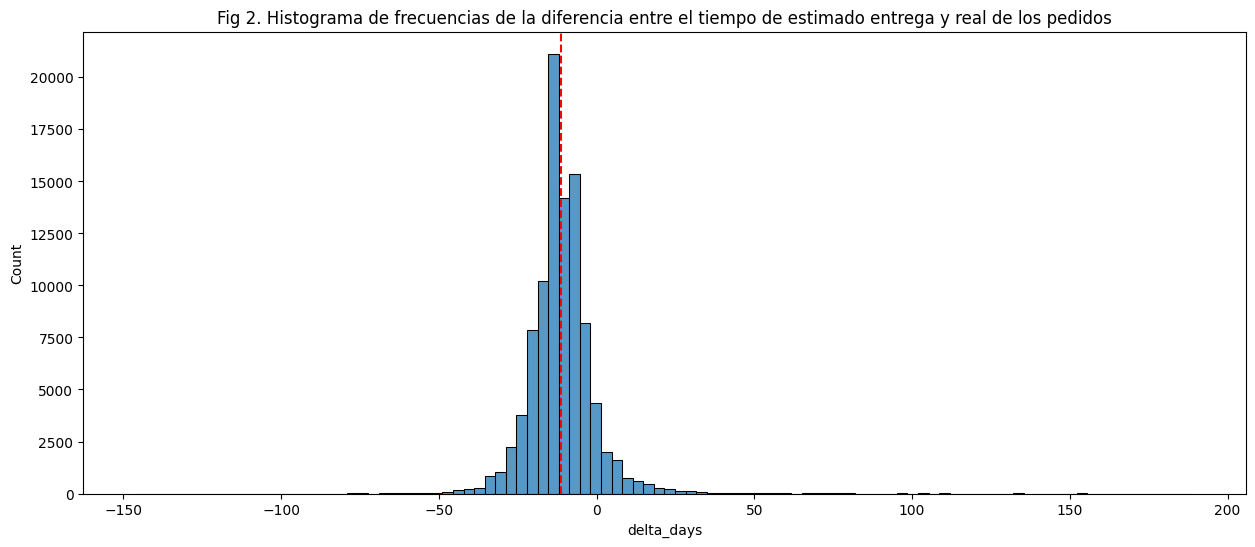

In [11]:
# Especifica el tamaño de la figura
plt.figure(figsize = (15,6))

# Crea al histograma
sns.histplot(
    data=delivered["delta_days"],
    bins=100
    ).set(title='Fig 2. Histograma de frecuencias de la diferencia entre el tiempo de estimado entrega y real de los pedidos')

# Agrega el promedio de la variable en estudio
plt.axvline(
    x=delivered["delta_days"].mean(), # p
    color='red',
    ls='--', 
    lw=1.5
    )

**Notas:** 1) En la figura se ha añadido el título usando la función `.set(title= '... texto ...')`, 2) además el promedio se ha dibujando echando mano de la función `axvline` de matplotlib, que como sabemos es la librería base con la que está construida Seaborn.

Como sabemos, existe forma alternativa de visualizar lo anterior denominada la **función de distribución acumulativa empírica**. 

Dicha herramienta es una manera de resumir datos y entender cómo se distribuyen los valores en un conjunto de datos, pues esencialmente, para una lista ordenada de números, nos permite entender cuántos de los valores son menores o iguales a un número específico y con ello entender de manera aproximada cuantos de los casos ocurren en la realidad y en que proporción, aproximando la probabilidad de un fenómeno.

En el caso de la variable `delta_days`, la **función de distribución acumulativa empírica** se puede visualizar mediante la función `ecdfplot`. En el **eje X** se tiene el valor de la variable en estudio y en el **eje Y** se encuentra la proporción de casos que corresponden a valores menores o iguales a los del **eje X** .

[Text(0.5, 1.0, 'Fig. 3 Función cumulativa de probabilidad de la diferencia \n entre el tiempo de estimado entrega y real de los pedidos')]

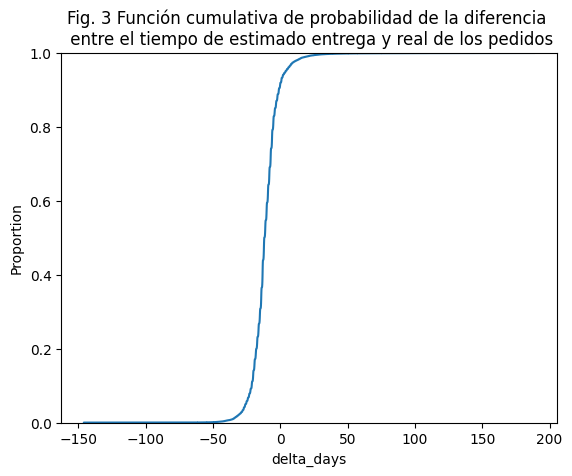

In [12]:
sns.ecdfplot(
    data=delivered,
    x="delta_days"
    ).set(
        title='Fig. 3 Función cumulativa de probabilidad de la diferencia \n entre el tiempo de estimado entrega y real de los pedidos'
        )

**Nota:** En este caso, le hemos especificado a Seaborn que el nombre del dataframe a emplear (`data=delivered`) y el valor que debe de emplear en el **eje X** mediante el nombre de la columna correspondiente (x="delta_days").

Como se aprecia, la proporción de casos en los que los pedidos llegan a tiempo `delta_days=0` correspode a un poco más del 90% de propoción de los mismos, es decir, hay una probabilidad muy alta de que los pedidos lleguen en tiempo.

#### 2.2.2 Diagramas de caja (Boxplots)

Una forma alternativa para estudiar la distribución de un conjunto numéricos de datos son los **diagramas de caja** o boxplots, estos representar a un conjunto de datos gráficamente valores estadísticos que los describen.

En términos simples, para un conjunto de datos numéricos, se realiza diagrama que se compone de un rectángulo
donde se indican el 1) rango intercuartil, es decir, el rango de valores que se encuentra entre el 25% de los datos (primer cuartil, Q1) y 75% de los datos (tercer cuartil, Q3), 2) la mediana de los datos (es decir, Q2) y 3) dos líneas, llamadas bigotes, que se extienden desde el rectángulo hasta los valores mínimo y máximo de los datos. Típicamente los valores que sobrepasan los bigotes se interpretan como valores atípicos de los datos.

Tales diagramas son útiles ayudan a entender cómo se distribuyen los datos en un conjunto y si hay valores extremos o fuera de lo común que pueden afectar el análisis de los datos.

En Seaborn, se pueden construir usando las funciones `boxplot` o `.catplot`, como en el ejemplo siguiente:


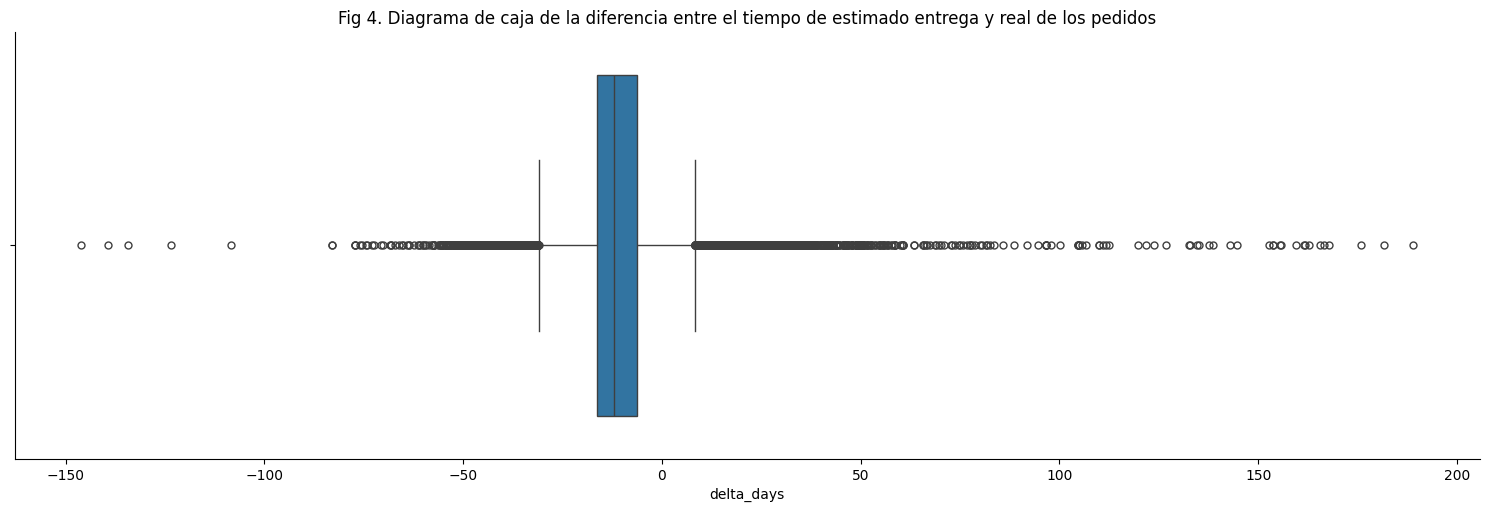

In [13]:
sns.catplot(
    data=delivered,
    x="delta_days",
    kind="box",
    height=5,
    aspect=3
    ).set(
        title='Fig 4. Diagrama de caja de la diferencia entre el tiempo de estimado entrega y real de los pedidos'
        )

Cabe destacar que el primer, segundo y tercer rango intercuartil se puede calcular mediante  la función `.describe` de Pandas:

In [14]:
delivered['delta_days'].describe()

count    96470.000000
mean       -11.178126
std         10.184354
min       -146.016123
25%        -16.244065
50%        -11.948102
75%         -6.389815
max        188.975081
Name: delta_days, dtype: float64

Como se aprecia, los datos de `delta_days` tienen los siguentes valores intercuartiles a) Q1: -16.23, b)Q2: -11.94, y c) Q3: -6.38, los cuales coindiden con las lineas inferior, mediay superior del rectángulo en la figura superior.

El rango intercuartil corresponde a la diferencia entre Q3 y Q1 (Q1-Q3), que en este caso es aproximadamente `9.85`.

Además, los límites de los bigotes típicamente se calculan a partir del rango intercuartil como sigue:
    * Limite bigote inferior: `Q1 - 1.75*(Q1-Q3)`
    * Limite bigote superior: `Q3 + 1.75*(Q1-Q3)`

En este caso, el bigote inferior se ubica en `-33.48` y el superior en `10.85`. Es decir, los valores extremos de la variable `delta_days` se ubican en entregas que se reciben hasta casi un mes antes de lo estimado y hasta casi después de 11 días de lo comunicado a los clientes de Oilst.

In [15]:
Q1 = -16.244065
Q3 = -6.389815
rango_inter = Q3 - Q1
bigote_inferior = Q1 - 1.75*rango_inter
bigote_superior = Q3 + 1.75*rango_inter

print("Rango intercuartil: ", rango_inter)
print("Bigote inferior: ", bigote_inferior)
print("Bigote superior: ", bigote_superior)

Rango intercuartil:  9.85425
Bigote inferior:  -33.4890025
Bigote superior:  10.8551225


#### 2.2.3 Series de tiempo

Dado que los fenómenos cambian a lo largo de la historia, también se pueden estudiar en su variación temporal. Para ello, se hechan mano de las series de tiempo, las cuales son herramienta que muestran como los datos evolucionan de un periodo determinado. Al hacerlo, se pueden identificar patrones y tendencias que no serían evidentes si sólo se mirara un conjunto de datos aislado.

En Seaborn, estas se pueden construir empleando la función `.lineplot`. En el siguiente ejemplo se construir la serie de tiempo de la cantidad de retrasos en los envíos por cada trimestre.




In [16]:
# Contamos la cantidad de envios con retrasos prolongados
orders_by_year = delivered.groupby(
    ['delay_status','year_month'])['order_id'].agg('count').reset_index().rename(
        columns={'year_month': 'period', 'order_id':'long_delays'}
        )

# Convertimos la fecha a texto
orders_by_year['period'] = orders_by_year['period'].astype(str)

In [17]:
orders_by_year

,delay_status,period,long_delays
0,long_delay,2016-09,1
1,long_delay,2016-10,1
2,long_delay,2017-01,20
3,long_delay,2017-02,44
4,long_delay,2017-03,94
...,...,...,...
60,short_delay,2018-04,116
61,short_delay,2018-05,214
62,short_delay,2018-06,29
63,short_delay,2018-07,121


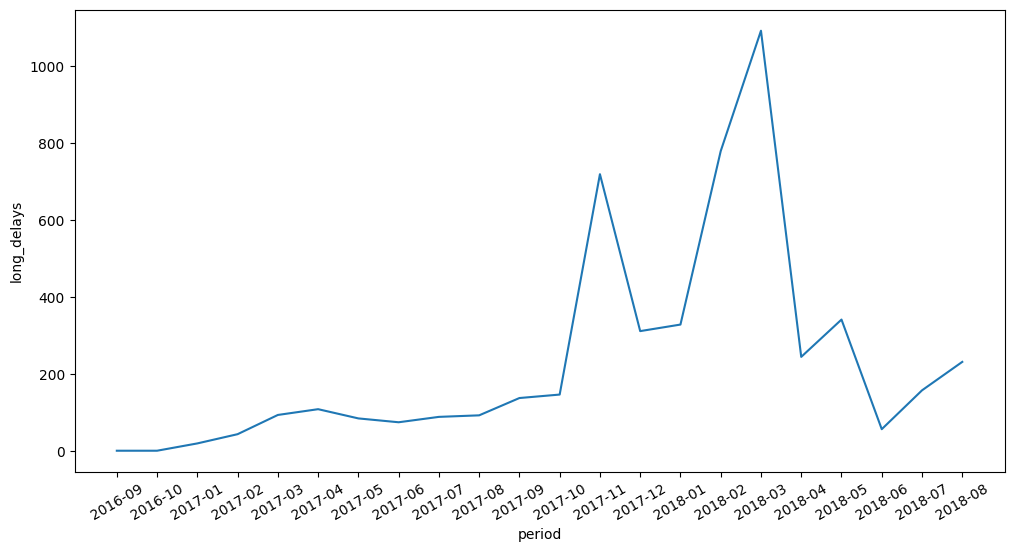

In [18]:
# Especifica el tamaño de la figura
plt.figure(figsize = (12,6))

sns.lineplot(
    data =orders_by_year.query("delay_status == 'long_delay'"),
    x='period',
    y='long_delays',
    ).tick_params(axis='x', labelrotation=30)

* ¿Existe alguna tendecia desde el Octubre de 2017 hasta marzo de 2018?

  Desde octubre de 2017 la curva sube con fuerza, alcanza su pico en febrero-marzo de 2018 y en abril comienza a descender. Se puede interpretar que en marzo del 2018, alcanzaron el limite de dias de retraso de entrega prolongado.

#### 2.2.3 Gráficas de barras

Es común que en los análisis se deban comparar diferentes categorías de un conjuntos de datos, para ello se suelen usar barrar que representan conteos o valores asociados a una categoría.

Típicamente el eje horizontal representa las diferentes categórías de una variable
y en el eje vertical se indica la altura correspodiente que debe tener una base y que indica la cantidad de datos relacionados con cada categoría.

Por ejemplo, si estás mostrando un gráfico de barras que representa la cantidad de ventas de diferentes productos en una tienda durante un mes, cada barra representaría un producto diferente y su altura representaría la cantidad de ventas de ese producto.

La librería Seaborn permite representar estos gráficos con las funciones `.catplot` (usando la indicación`kind="count"`) y `.barplot` (https://seaborn.pydata.org/tutorial/categorical.html y https://seaborn.pydata.org/generated/seaborn.barplot.html)

En la parte inferior se muestra el conteo de la cantidad de órdenes que existe de acuerdo a si llegaron a tiempo o bien su fueron entregadas con un retraso moderado o prologado.

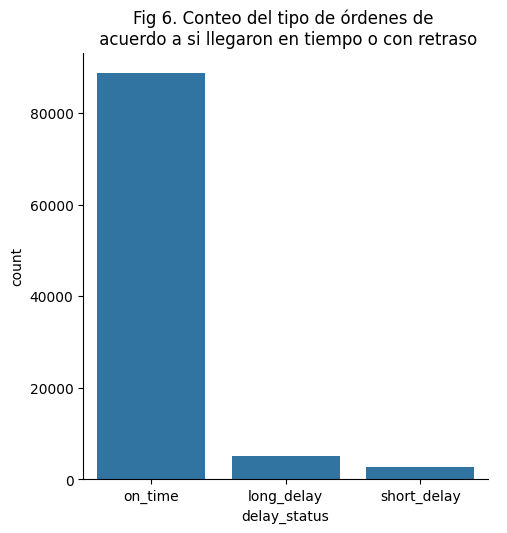

In [19]:
sns.catplot(
    data=delivered,
    x="delay_status",
    kind="count"
    ).set(
        title='Fig 6. Conteo del tipo de órdenes de \n acuerdo a si llegaron en tiempo o con retraso'
        )

Dicha gráfica es la representación de la cantidad de elementos en cada categoría como se aprecia abajo:

In [20]:
delivered.groupby(['delay_status'])['order_id'].agg('count')

delay_status
long_delay      5164
on_time        88644
short_delay     2670
Name: order_id, dtype: int64

## 3. Análisis Bivariado

Dado que en la realidad los fenómenos suelen involucrar más de un factor, es importante estudiar la relación entre varias variables.

### 3.1 Gráficos de dispersión

Un gráfico de dispersión es una herramienta visual que se utiliza para mostrar la relación entre dos variables. En general, se representa una variable en el eje horizontal (el eje X) y otra en el eje vertical (el eje Y). Cada punto en el gráfico representa un par de valores de ambas variables.

Al trazar los puntos en el gráfico de dispersión, podemos observar si hay una relación entre las dos variables. Si los puntos tienden a agruparse en una línea recta diagonal, esto indica una correlación positiva, lo que significa que a medida que una variable aumenta, la otra también lo hace. Por otro lado, si los puntos se distribuyen de manera aleatoria, esto indica una falta de correlación o una correlación débil.

Seaborn nos permite construir diagramas de dispersión con la función `.relplot`. En la parte inferior, se muestra el diagrama de dispersión entre las ventas de las órdenes y sus tiempos de entrego con respecto a lo estimado.


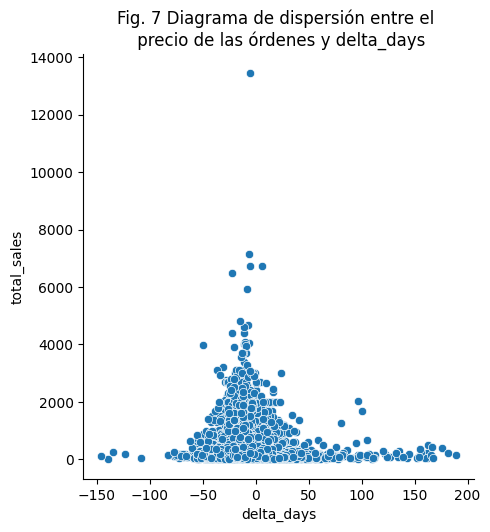

In [21]:
# Create a visualization
sns.relplot(
    data=delivered,
    x="delta_days",
    y="total_sales",
).set(
    title='Fig. 7 Diagrama de dispersión entre el \n precio de las órdenes y delta_days'
        )

No se aprecia claramente algún efecto de correlación lineal positiva o negativa entre ambas. Es decir, no se puede concluir que el tiempo de entrega se afecte por el precio total de las órdenes.

**Pregunta:**

* ¿Qué sucede si observamos el diagrama de dispersión para `delta_days` y la distancia al centro de distribución más cercano?

  Si observamos el diagrama, notamos que conforme aumenta la distancia al centro de distribución también crecen los retrasos en días, lo que confirma una clara relación positiva entre ambas variables.

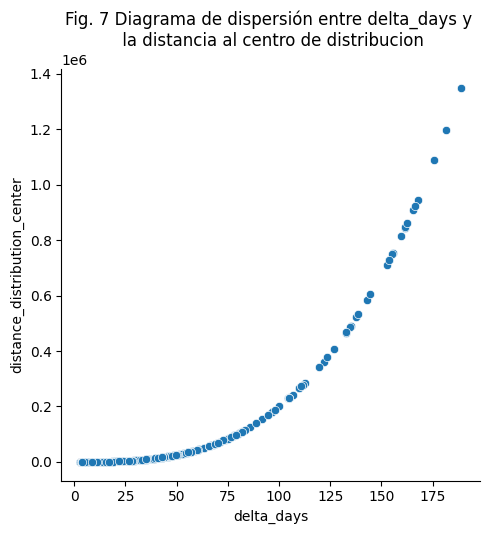

In [22]:
# Create a visualization
sns.relplot(
    data=delivered.query("delay_status == 'long_delay'"),
    x="delta_days",
    y="distance_distribution_center",
).set(
    title='Fig. 7 Diagrama de dispersión entre delta_days y \n la distancia al centro de distribucion'
        )

**Preguntas:**

Para las órdenes donde existieron retrazos prolongados:

* ¿Existe alguna relación entre la distancia al centro de distribución más cercano y la cantidad de días en que se tardó en llegar la entrega después de la fecha estimada?

  Sí, existe una relación clara: a mayor distancia al centro de distribución, más grande es el retraso en días.
  
* Si es así, ¿que típo de relación existe y que implicación tiene sobre el e-commerce?

  La relación es positiva y no lineal (los retrasos crecen de forma acelerada con la distancia).

### 3.2 Gráficos de caja para varias variables

Del mismo modo que en el caso de una variable, también se pueden hacer gráficos de caja para entender la distribución de una variable numérica a lo largo de las diferentes categorías de otra variable.

Para ello, se pueden aprovechar las funciones `boxplot` o `.catplot` como en el ejemplo siguiente:

[Text(0.5, 1.0, 'Fig. 8 Diagramas de caja de la variable delay_status \n vs el valor monetario de las órdenes')]

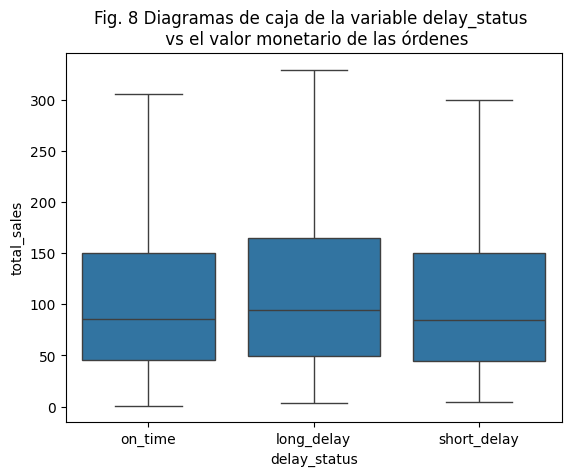

In [23]:
# Usamos la variable showfliers = False para omitir
# los valores atipicos del grafico

sns.boxplot(
    data=delivered,
    x="delay_status",
    y="total_sales",
    showfliers = False
    ).set(
        title='Fig. 8 Diagramas de caja de la variable delay_status \n vs el valor monetario de las órdenes'
        )

[Text(0.5, 1.0, 'Fig. 8 Diagramas de caja de la variable delay_status \n vs distance_distribution_center')]

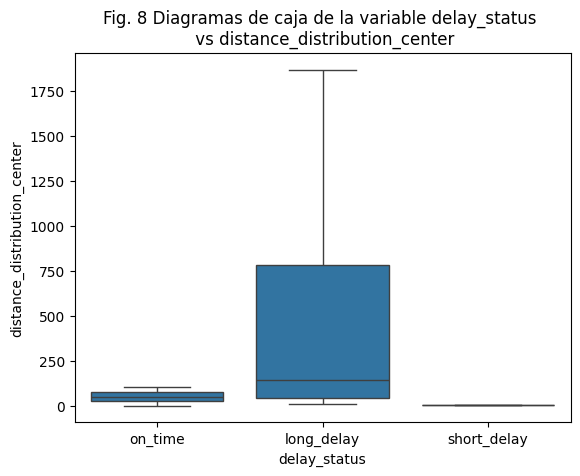

In [24]:
sns.boxplot(
    data=delivered,
    x="delay_status",
    y="distance_distribution_center",
    showfliers = False
    ).set(
        title='Fig. 8 Diagramas de caja de la variable delay_status \n vs distance_distribution_center'
        )

**Pregunta:**

* ¿Existen diferencias significativas entre el tipo de retrasos en la órdenes y el precio total que pagaron los clientes por ellas?

  No existen diferencias notables en el valor monetario de las órdenes entre entregas a tiempo, con retraso corto o retraso largo. Las medianas son muy similares y las dispersiones se superponen, lo que indica que el monto pagado por los clientes no está fuertemente relacionado con la ocurrencia de retrasos.


* ¿Qué es lo que se observa si se construye el mismo gráfico pero comparando las variables `delay_status` vs `distance_distribution_center`?

  Las órdenes a tiempo y con retrasos cortos suelen estar asociadas a distancias pequeñas al centro de distribución. Los retrasos largos presentan distancias mucho mayores y una dispersión amplia, indicando que a mayor distancia al centro, más probabilidades de sufrir demoras significativas.

### 3.2 Matriz de correlación lineal

Una matriz de correlación es una herramienta que se utiliza para analizar la relación lineal entre varias variables. En esencia, lo que hace es medir cuánto se parecen dos variables y cuánto se influyen mutuamente.

En una matriz de correlación, cada variable se representa en una columna y una fila. La diagonal principal de la matriz muestra la correlación de cada variable consigo misma (es decir, su "correlación" perfecta, que es 1). Las celdas fuera de la diagonal muestran la correlación entre dos variables diferentes. La correlación se expresa en un número entre -1 y 1, donde -1 significa que las dos variables están completamente inversamente relacionadas (si una aumenta, la otra disminuye) y 1 significa que las dos variables están completamente relacionadas (si una aumenta, la otra también lo hace).

Seaborn permite graficar la matriz de correlación con la función `.heatmap`



In [25]:
cols_corr = [
    'total_sales',
    'total_products',
    'delta_days',
    'distance_distribution_center'
    ]

matrix_corr = delivered.filter(cols_corr).corr()   

In [26]:
matrix_corr

,total_sales,total_products,delta_days,distance_distribution_center
total_sales,1.000000,0.153476,-0.013643,0.006904
total_products,0.153476,1.000000,-0.032026,-0.002395
delta_days,-0.013643,-0.032026,1.000000,0.331162
distance_distribution_center,0.006904,-0.002395,0.331162,1.000000


[Text(0.5, 1.0, 'Fig. 9 Matriz de correlación de las órdenes')]

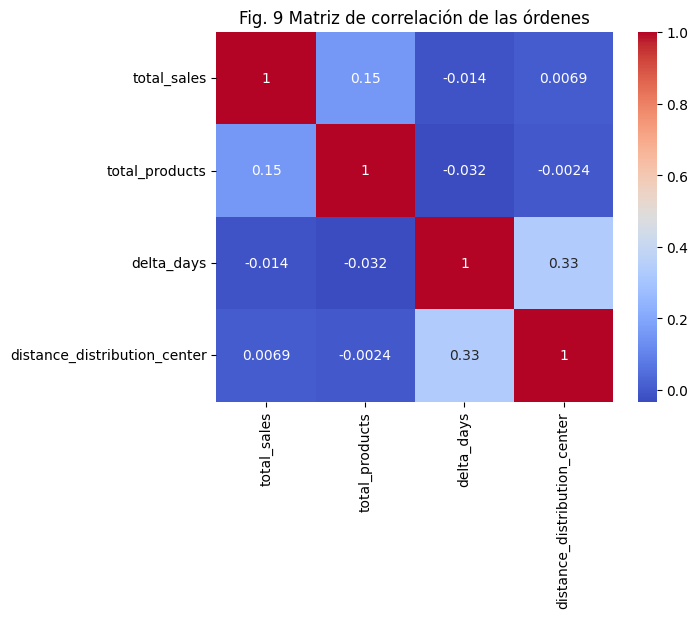

In [27]:
sns.heatmap(
    matrix_corr,
    cmap="coolwarm",
    annot=True).set(
        title='Fig. 9 Matriz de correlación de las órdenes'
        )


**Pregunta:**

* ¿De la matriz de correlación anterior, se identifica relación directa entre alguna de las variables?

  No se observa una relación fuerte entre las variables. La mayoría de las correlaciones son muy cercanas a 0. El valor más alto es entre delta_days y distance_distribution_center (0.33), lo que indica una correlación positiva moderada, a mayor distancia desde el centro de distribución, tiende a haber un poco más de retraso.
  
* ¿Qué sucede que si graficamos la misma matriz matriz de correlación pero restringiendo los datos a órdenes que tuvieron únicamente retrazos prologados?

  La correlación entre delta_days y distance_distribution_center aumenta fuertemente a 0.76, lo que muestra una relación positiva y bastante significativa entre ambas variables.

* ¿De lo anterior, existe alguna relación entre `delay_days` y otra de las variables?

  Si, delay_days tiene una correlación muy fuerte (0.76) con distance_distribution_center, lo cual no se observa de manera tan marcada en la matriz general (0.33). Esto confirma que la distancia al centro de distribución es un factor determinante para explicar la duración de los retrasos.
  
* ¿Qué implica esto para el negocio de Oilst con respecto a los retrazos en las órdenes?

  Implica que el factor geográfico influye de forma directa en la probabilidad y severidad de los retrasos. Para el negocio, esto significa que deberían plantearse estrategias logísticas como abrir centros de distribución más cercanos a zonas lejanas, optimizar rutas de transporte, o usar aliados locales.

[Text(0.5, 1.0, 'Fig. 10 Matriz de correlación de las órdenes completadas con retrazo prolongado')]

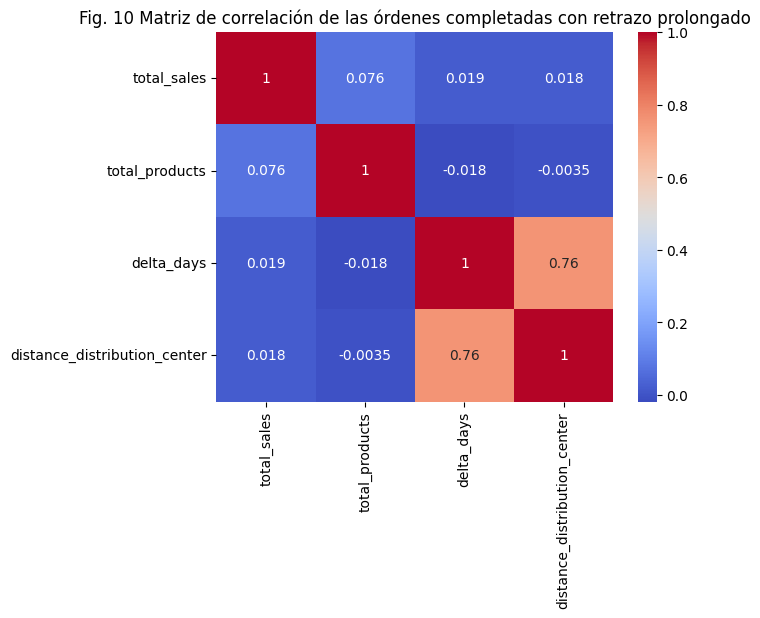

In [28]:
sns.heatmap(
    delivered.query("delay_status == 'long_delay'").filter(cols_corr).corr()   ,
    cmap="coolwarm",
    annot=True).set(
        title='Fig. 10 Matriz de correlación de las órdenes completadas con retrazo prolongado'
        )

## 4. Análisis Multivariado

Para ahondar aún mas en el análisis, se puede incluir más de dos variables en las representaciones gráficas. En términos generales, se trata el mismo tipo de gráficos de Seaborn que se han abordado previamente, pero incluyendo parámetros que segmentan las visualizaciones como `hue` y `col`.

### 4.1 Diagramas de pares o pair plots

Un diagrama de pares es una herramienta visual que se utiliza para explorar la relación entre varias variables. Es especialmente útil cuando se desea analizar la correlación entre las variables y cómo cambian juntas en función del tiempo, la ubicación geográfica u otros factores.

En un diagrama de pares, se representan varias variables en un plano cartesiano, donde cada variable se ubica en uno de los dos ejes. Cada punto en el gráfico representa una observación en la muestra de datos, donde la posición en el eje X representa el valor de una variable y la posición en el eje Y representa el valor de la otra variable.

De esta forma se pueden revisar de manera conjunta como cambian la distribución de un fenómeno de manera multi-factorial. 

En seaborn, dicha representación se puede crear con la función `pairplot` (https://seaborn.pydata.org/generated/seaborn.pairplot.html), la cual permite incorporar cortes adiciones con variables categórica especificada.

Observemos el siguiente ejemplo, donde se confrotan digramas de dispersion e histogramas de frecuendias de las variables `delay_status`, `total_sales`, `total_products`, `delta_days` y `distance_distribution_center`:

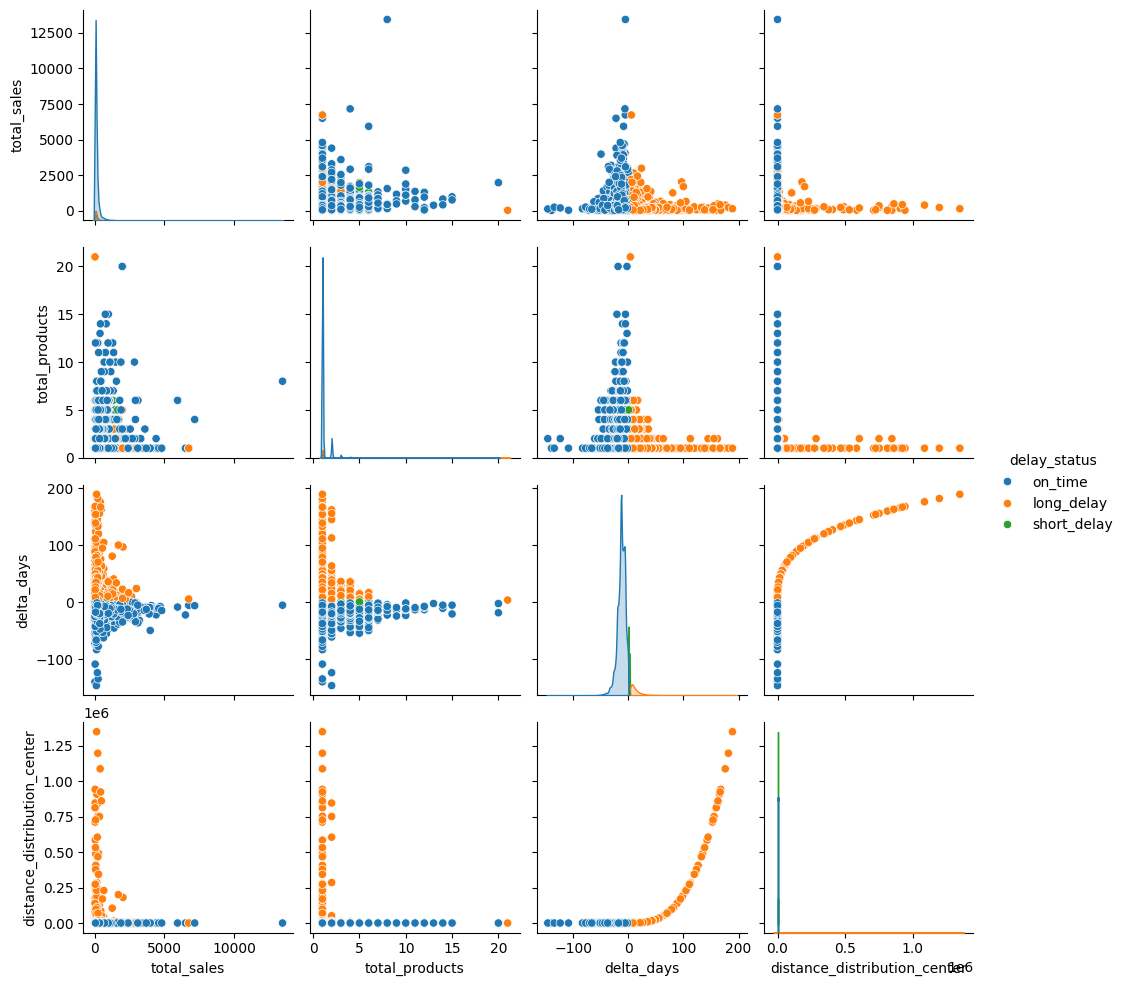

In [29]:
# Nota: la ejecucion de este diagrama puede tardar
# Dado que crea muchos graficos distintos

sns.pairplot(
    data=delivered.filter(
        [
            "delay_status",
            "total_sales", 
            "total_products",
            "delta_days",
            "distance_distribution_center"
        ]
        ),
    hue="delay_status"
    )

**Pregunta:**

* ¿Se puede concluir la existencia de relación lineal entre alguna variable de acuerdo al grupo `delay_status`?

  La única relación lineal que se puede destacar está entre delta_days y distance_distribution_center para el grupo con retraso prolongado (long_delay). Para los demás grupos y combinaciones de variables no se observan relaciones lineales significativas.

### 4.2 Uso de la variable `hue`

Como se ha mencionado antes, las implementaciones de Seaborn son muy flexibles y permite añadir segmentaciones de una visualización usando los mismos códigos que antes, pero segmentando por una variable categórica especificada en la variable `hue='nombre_variable_categórica'`.

A continuación se presentan algunos ejemplos de visualizaciones ya implementadas:

**Histogramas**

[Text(0.5, 1.0, 'Histograma de frecuencias de la diferencia de la variable delta_days \n por tipo de tipo de orden')]

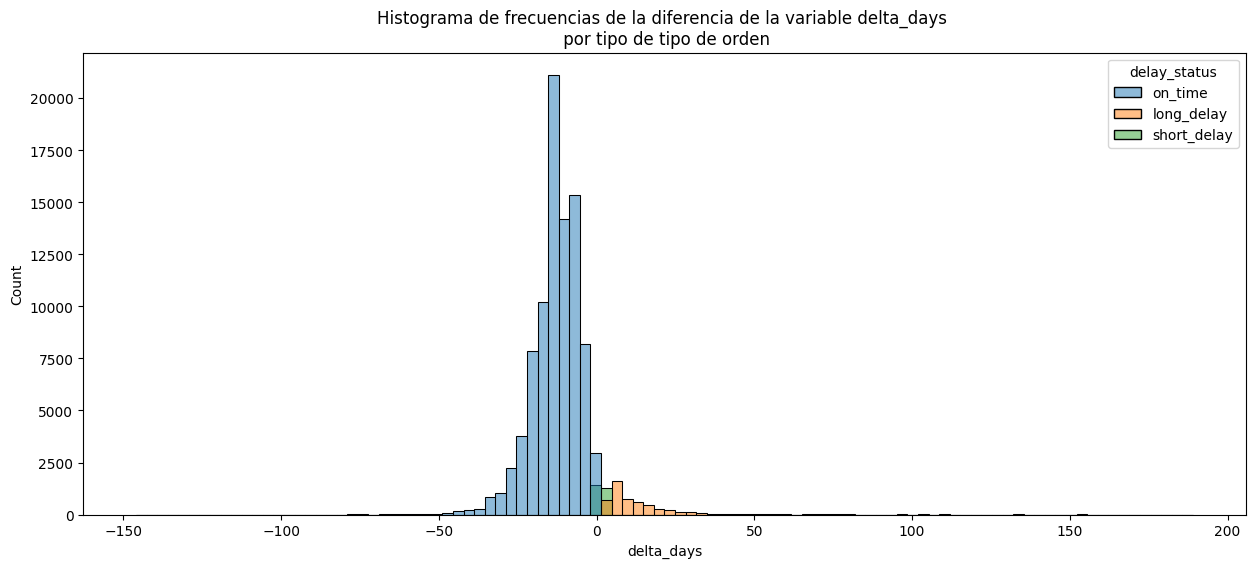

In [30]:
# Especifica el tamaño de la figura
plt.figure(figsize = (15,6))

# Genera el histograma
sns.histplot(
    data=delivered,
    x="delta_days",
    hue="delay_status",
    bins=100
    ).set(
        title='Histograma de frecuencias de la diferencia de la variable delta_days \n por tipo de tipo de orden'
        )

**Series de Tiempo**

A continuación se presentar la serie de tiempo de la cantidad de ordenes al mes, de acuerdo a si se entregaron en tiempo o bien con un retraso moderado o prolongado.

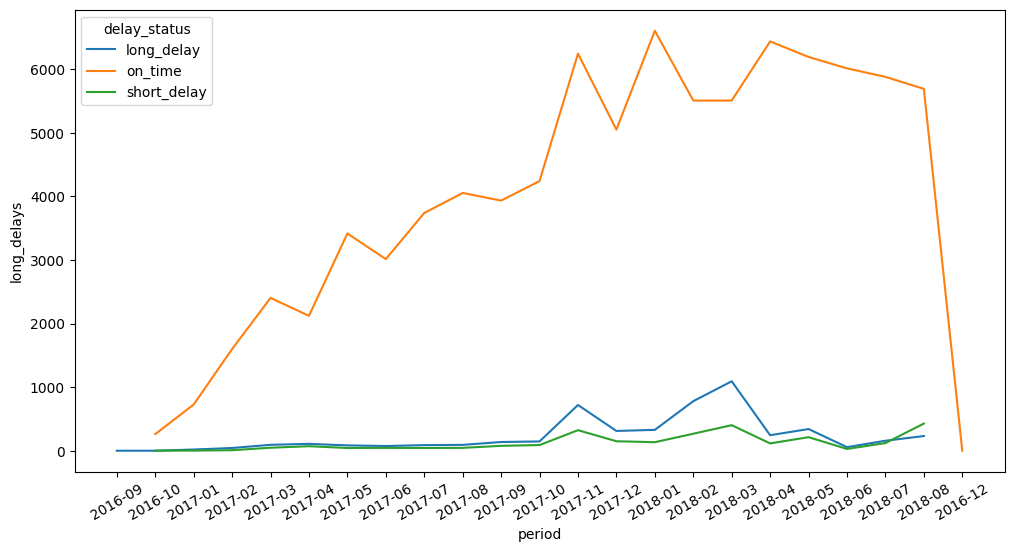

In [31]:
# Especifica el tamaño de la figura
plt.figure(figsize = (12,6))

sns.lineplot(
    data =orders_by_year,
    x='period',
    y='long_delays',
    hue="delay_status"
    ).tick_params(axis='x', labelrotation=30)

### 4.3 Uso de las variables `col` y `row`

Otra forma de segmentar las visualizaciones es segmentar aplicando una variable categórica por columnas o reglones, esto se logra especificando el nombre de la variable de la forma `col='nombre_variable'` o bien `row='nombre_variable'`.

**Diagrama de dispersión**

En la siguiente visualización se observa como se apertura un diagrama de dispersión por renglones a especificar la variable `row="delay_status"`, con lo que se aprecia las diferencias de la dispersión entre la distancia al centro de distribución y el tiempo de entrega.

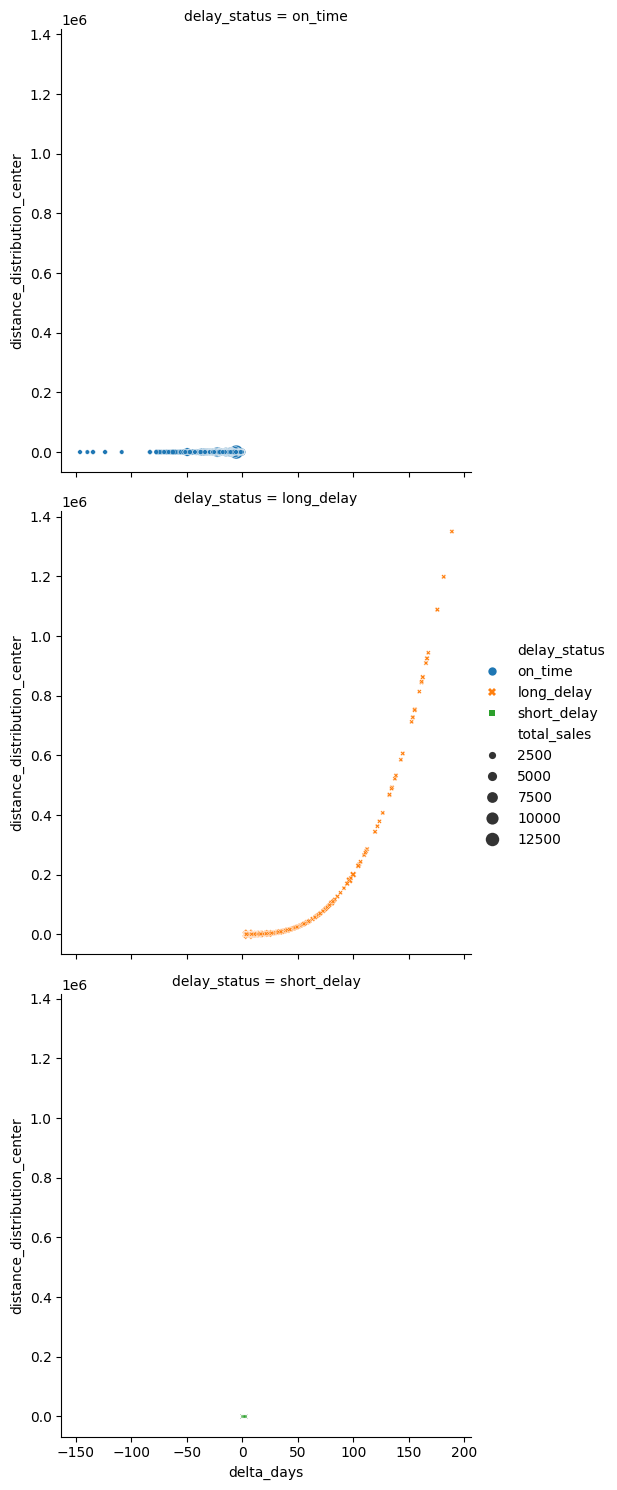

In [32]:
sns.relplot(
    data=delivered,
    x="delta_days",
    y="distance_distribution_center",
    row="delay_status",
    hue="delay_status",
    size="total_sales",
    style="delay_status",
    sizes=(10, 100)
)

## 5. Entregables

En esta sección los entregables consisten en un script en Python junto con un imagen en un archivo en formato específico:

A. Script que construya una visualización que permita comparar los histogramas de las ventas de órdenes completas que tuvieron retrazos moderados y prolongados. Este script tendrá el nombre `3_a_histogram_sales_short_long_delays.py` y la imagen resultante deberá denominarse `3_a_histogram_sales_short_long_delays.png`.

B. Programa que cree una visualización de la matriz de correlación de `delta_days` junto con el resto de variables numéricas, para las órdenes en las que se concretó su entrega. Este script se denominará `3_b_correlation_matrix_complete_orders.py` y su resultado será una figura llamada `3_b_correlation_matrix_complete_orders.png`.

C. Script que construya una visualización los diferentes diagramas de cajas de la `delta_days` a lo largo de los estados de Brasil. Dicha visualización deberá segmentarse o aperturarse de forma que permita revisar en una misma figura como varian los diagramas de caja también para órdenes que tuvieron diferentes valores del campo `delay_status` a lo largo de los estados brasileños. Dicho script se llamarán `3_c_boxplot_delta_day_by_state_and_delay_type.py` y la figura resultante del mismo se denominará `3_c_boxplot_delta_day_by_state_and_delay_type.png`. Hint: Revisar la documentación de `.catplot`

**NOTA** Se decidió implementar todos los entregables en un único archivo Jupyter Notebook en lugar de crear scripts .py separados, ya que esto permite concentrar el análisis, el código y las visualizaciones en un solo lugar, facilitando la ejecución y la interpretación de los resultados; sin embargo, las imágenes generadas mantienen los nombres solicitados en las instrucciones para cumplir con los entregables requeridos.

#### 5.A. Histograma de ventas para retrasos moderados y prolongados

In [33]:
retrasos = delivered.query("delay_status in ['short_delay', 'long_delay']")

plt.figure(figsize=(15, 6))
sns.histplot(
    data=retrasos, 
    x="total_sales",
    hue="delay_status",
    bins=40,
    palette={"short_delay": "orange", "long_delay": "red"},
    hue_order=["short_delay", "long_delay"],
    multiple="dodge"
    )

# Etiquetas y título descriptivo
plt.title("Histograma comparativo de ventas\nRetrasos moderados vs prolongados")
plt.xlabel("Ventas (total_sales)")
plt.ylabel("Frecuencia de órdenes")

# Leyenda
plt.legend(title="Tipo de retraso", labels=["Retraso moderado", "Retraso prolongado"])

# Guardar
plt.savefig("3_a_histogram_sales_short_long_delays.png")
plt.close()

#### 5.B. Matriz de correlación de órdenes entregadas

In [34]:
sns.heatmap(
    matrix_corr,
    cmap="coolwarm",
    annot=True).set(
        title='Matriz de correlación - Órdenes entregadas'
        )

# Guardar
plt.tight_layout()
plt.savefig("3_b_correlation_matrix_complete_orders.png")
plt.close()

#### 5.C. Boxplots de delta_days por estados de Brazil y tipos de retrasos

In [35]:
# Usamos catplot para generar múltiples boxplots
g = sns.catplot(
    data=delivered,
    x="customer_state",
    y="delta_days",
    hue="delay_status",
    kind="box",
    height=5,
    aspect=3
).set(
    title='Diagramas de caja de delta_days por estado y tipo de retraso'
        )

#Titulo para los ejes X y Y
g.set_axis_labels("Estado", "Diferencia en días (delta_days)")

# Reubicar la leyenda
g._legend.set_bbox_to_anchor((0.9, 1))
g._legend.set_loc("upper center")

# Guardar
plt.savefig("3_c_boxplot_delta_day_by_state_and_delay_type.png",
    bbox_inches="tight"
)
plt.close()